In [1]:
import csth.utils.pmaps_functions           as pmapsf
import csth.utils.hpeak_pmaps_newfunctions  as hppmap

import krcal.dev.corrections                as corrections

from csth.images.imageDataFrame        import imageDataFrame
from invisible_cities.database.load_db import DataSiPM

from csth.images.IMAGE import IMAGE

import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec
import matplotlib.patches   as patches

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path         import Path
from matplotlib.widgets      import Slider

In [2]:
# Plotting style
figure_size  = 9, 5
#font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
#plt.rcParams[  "font.size"   ] =   font_size

#plt.style.use(plt.style.available[10])

## Event data

In [3]:
run  = 6206
ev   = 5527071
loc  = 50
typo = 'Tlds'

In [4]:
datasipm = DataSiPM(run)
datadir  = f'/home/gonzalo/Documentos/NEXT/CsThNB/GDL/selected_pmaps/{run}/pmaps_{loc}_{run}_{typo}.h5'
data     = pd.HDFStore(datadir)

s1   , s2   , s2si    = data['s1']      ,  data['s2']     , data['s2si']
s1_ev, s2_ev, s2si_ev = s1[s1.event==ev], s2[s2.event==ev], s2si[s2si.event==ev]

In [5]:
imagedf = imageDataFrame(s1_ev, s2_ev, s2si_ev, datasipm)
im = IMAGE(imagedf, datasipm, run, ev, typo)

<IPython.core.display.Javascript object>


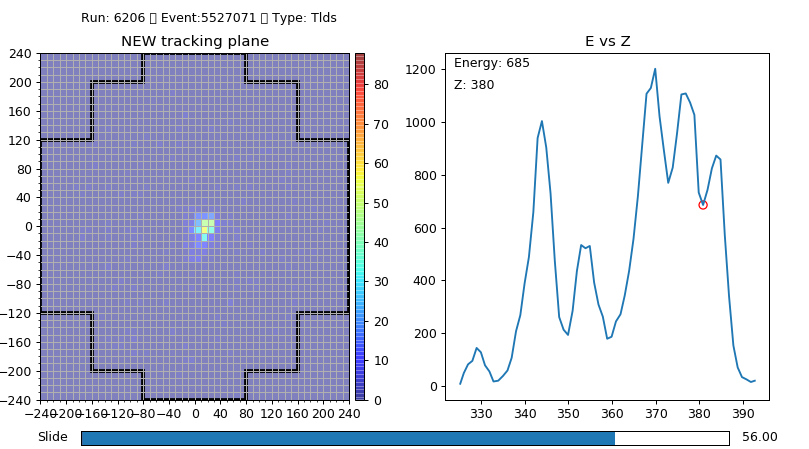

In [6]:
im.Movie_Slider()
im.fig.show();

<IPython.core.display.Javascript object>


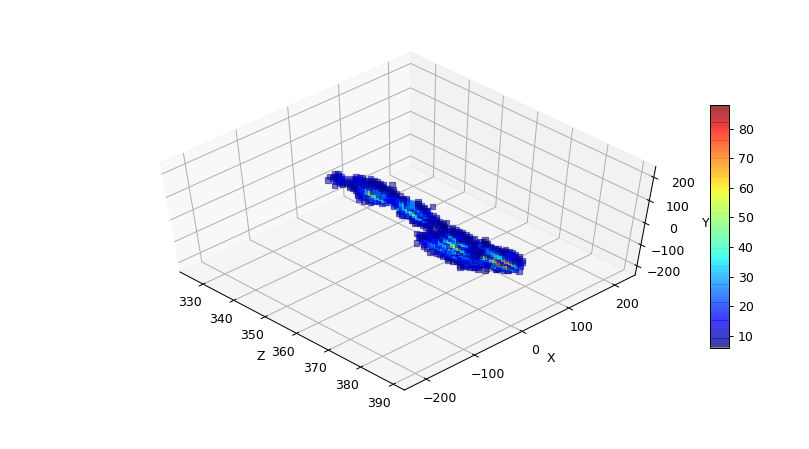

In [9]:
im.plot3d(cut=6)
im.fig.show()

## Corrected image

In [10]:
pmaps =  pmapsf.get_pmaps(datadir, 'gd')

In [11]:
xpos, ypos = datasipm.X.values, datasipm.Y.values
evt = ev
ipk = 0
correction_filename = f'/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5'
calibrate = corrections.Calibration(correction_filename, 'scale')
x0ij, y0ij, z0ij, eij = hppmap.get_event_hits(pmaps, evt, ipk, calibrate, xpos, ypos)

calibration file : /home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run6206.h5
node             : scale
Energy   scale : 10069.6 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale : 598.7 (pes)


In [12]:
imagedf = pd.DataFrame(columns=['X', 'Y', 'Z', 'E'])
imagedf['X'], imagedf['Y'], imagedf['Z'], imagedf['E'] = x0ij, y0ij, z0ij, eij

In [13]:
im = IMAGE(imagedf, datasipm, run, ev, typo)

In [14]:
im.plot3d()

<IPython.core.display.Javascript object>


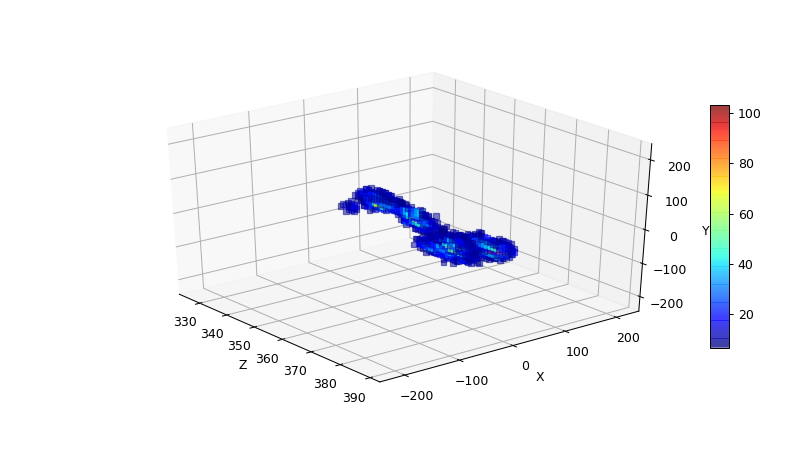

In [15]:
im.fig.show()

In [16]:
im.Movie_Slider()

<IPython.core.display.Javascript object>


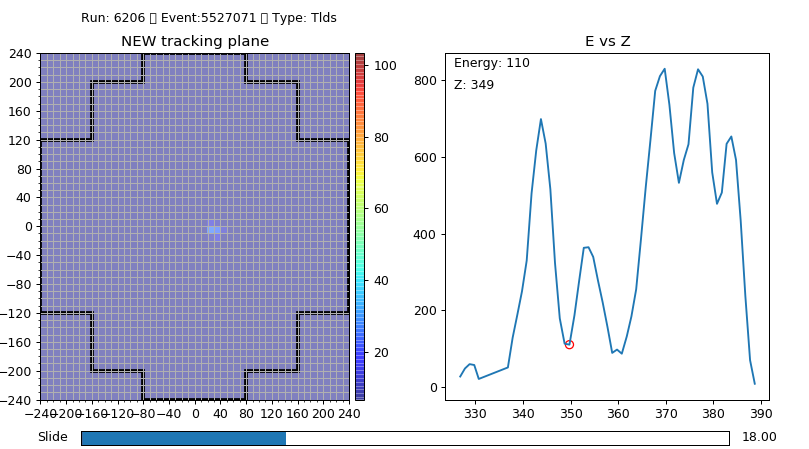

In [17]:
im.fig.show()

In [ ]:
class IMAGE:

    def __init__(self, imagedf, times, datasipm, run, event, typo):
        self.im  = imagedf
        self.tim = times
        self.dsi = datasipm
        self.r   = run
        self.ev  = event
        self.ty  = typo

        self.fig  =  plt.figure(constrained_layout=True)
        self.si_enes = []
        self.bins  = [0, 0]
        self.rg    = 0
        self.edges = [0, 0]
        self.axim = 0
        self.etim = 0
        self.e =0
        self.t =0
        self.cir = 0
        self.sl  = 0


    def _initvalues(self):
        d = 10 #distance between Sipms

        x   , y    =  self.dsi['X'], self.dsi['Y']
        xmin, xmax =  x.min()      , x.max()
        ymin, ymax =  y.min()      , y.max()

        nx  , ny   = (xmax-xmin)/10 + 1   , (ymax-ymin)/10 + 1
        rg         = [[xmin-d/2, xmax+d/2], [ymin-d/2, ymax+d/2]]

        H, xedges, yedges = np.histogram2d(x, y, bins = [nx, ny], range = rg)
        H = H.T

        for time in self.tim:
            self.si_enes.append(self.im[self.im.time == time]['ene'].sum())

        self.bins  = [nx, ny]
        self.rg    = rg
        self.edges = [xedges, yedges]
        return H


    def init_figure(self):
        spec = gridspec.GridSpec(ncols=2, nrows=1, left=0.05, right=0.95, wspace=0.25)

        ax  = self.fig.add_subplot(spec[0, 0], title='NEW tracking plane')
        ax1 = self.fig.add_subplot(spec[0, 1], title='E vs T')

        H = self._initvalues()

        #TRACKING PLANE
        enemin, enemax  = self.im['ene'].min(), self.im['ene'].max()
        xedges, yedges  = self.edges[0]       , self.edges[1]
        self.axim = ax.imshow(H, cmap='jet', vmin = enemin, vmax = enemax, interpolation='nearest',
                         origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], alpha = 0.5,
                         aspect='auto')

        #ticks of 1 cm^2
        maxt, mixt = _each(xedges, n = 4)
        ax.set_xticks(maxt, minor = False)
        ax.set_xticks(mixt, minor = True)

        mayt, miyt = _each(yedges, n = 4)
        ax.set_yticks(mayt, minor = False)
        ax.set_yticks(miyt, minor = True)
        #colorbar
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes("right", size="3%", pad=0.07)
        cbar    = self.fig.colorbar(self.axim, cax = cax);

        # E vs T AXES
        self.etim, = ax1.plot(self.tim, self.si_enes)


    def _figure_customize(self):
        self.fig.text    ( .1, .95 , f'Run: {self.r} \t Event:{self.ev} \t Type: {self.ty}');
        #self.fig.text    ( .1, .9  , 'Event number: {}'.format(self.ev));
        #self.fig.text    ( .1, .85 , 'Event type: {}'  .format(self.ty));
        e = self.fig.text( .56, .85 , 'Energy: {}'      .format(''));
        t = self.fig.text( .56, .8 , 'Time: {}'        .format(''));
        self.e = e
        self.t = t


    def _TP_customize(self):
        # grid, detector contourn
        ax = self.fig.axes[0]
        ax.grid(which='both');
        patch = _NEW_TP_edge()
        ax.patch.set_animated(True);
        ax.add_patch(patch);


    def _ET_customize(self, xy):
        #draw circle (taken from https://werthmuller.org/blog/2014/circle/)
        # circle centre
        radius = .01
        ax1 = self.fig.axes[1]

        pr      = self.fig.get_figwidth()/self.fig.get_figheight()
        tscale  = ax1.transScale + (ax1.transLimits + ax1.transAxes)
        ctscale = tscale.transform_point(xy)
        cfig    = self.fig.transFigure.inverted().transform(ctscale)

        cir = patches.Ellipse(cfig, radius, radius*pr,
        transform=self.fig.transFigure, facecolor = 'none', edgecolor = 'r')

        ax1.add_artist(cir);

        self.cir = cir


    def update(self, frame_number):
        '''Update function for plots'''
        frame_number = int(frame_number)
        #sl.set_val(frame_number)
        #TRACKING PLANE
        imdf = self.im[self.im.time == self.tim[frame_number]]
        x, y, w = imdf['X'], imdf['Y'], imdf['ene']
        H, __, __ = np.histogram2d(x, y, weights = w, bins = self.edges, range = self.rg)
        H = H.T
        self.axim.set_data(H)

        #ENERGY VS TIME plot
        ax1 = self.fig.axes[1]
        xy = (self.tim[frame_number], w.sum())
        tscale   = ax1.transScale + (ax1.transLimits + ax1.transAxes)
        ctscale  = tscale.transform_point(xy)
        cfig     = self.fig.transFigure.inverted().transform(ctscale)
        self.cir.center = cfig

        # figure text actualization
        self.e.set_text('Energy: {}'.format(int(w.sum())))
        self.t.set_text('Time: {}'  .format(int(self.tim[frame_number])))

        self.fig.canvas.draw_idle()


    def Movie_Slider(self):
        self.init_figure()
        self._figure_customize()
        self._TP_customize()
        self._ET_customize(xy = (self.tim[0], self.si_enes[0]))


        #Slider plot creation
        caxsl = plt.axes([0.1, 0.01, 0.8, 0.03], facecolor=None)
        self.sl = Slider(caxsl, 'T', 0, len(self.tim)-1, valinit = 0, valstep = 1)
        self.sl.on_changed(self.update);